# Install

In [1]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 12.7 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')

from glob import glob
import pandas as pd
import numpy as np 
from tqdm import tqdm
from tqdm.auto import tqdm
import cv2

import os
import timm
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, accuracy_score
import time


device = torch.device('cuda')
SEED = 42

In [3]:
torch.cuda.is_available()

False

# Data Load

In [4]:
train_png = sorted(glob('/content/drive/MyDrive/경쟁모드/김유환/data/train512/*.png'))
test_png = sorted(glob('/content/drive/MyDrive/경쟁모드/김유환/data/test512/*.png'))

In [5]:
def img_load(path):
    img = cv2.imread(path)[:,:,::-1]
    return img

In [ ]:
train_imgs = [img_load(m) for m in tqdm(train_png)]
test_imgs = [img_load(n) for n in tqdm(test_png)]

  0%|          | 0/4277 [00:00<?, ?it/s]

  0%|          | 0/2154 [00:00<?, ?it/s]

# EDA

In [ ]:
train_y  = pd.read_csv("/content/drive/MyDrive/data engineering/Deep Learning/project/open/train_df.csv")
test = pd.read_csv("/content/drive/MyDrive/data engineering/Deep Learning/project/open/test_df.csv")

train_labels = train_y["label"]

label_unique = sorted(np.unique(train_labels))
label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))}

train_labels = [label_unique[k] for k in train_labels]

In [ ]:
train_y.head()

,index,file_name,class,state,label
0,0,10000.png,transistor,good,transistor-good
1,1,10001.png,capsule,good,capsule-good
2,2,10002.png,transistor,good,transistor-good
3,3,10003.png,wood,good,wood-good
4,4,10004.png,bottle,good,bottle-good


In [ ]:
train_y['class'].nunique()

15

In [ ]:
train_y['state'].nunique()

49

In [ ]:
train_y['label'].nunique()

88

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

<AxesSubplot:xlabel='class', ylabel='Count'>

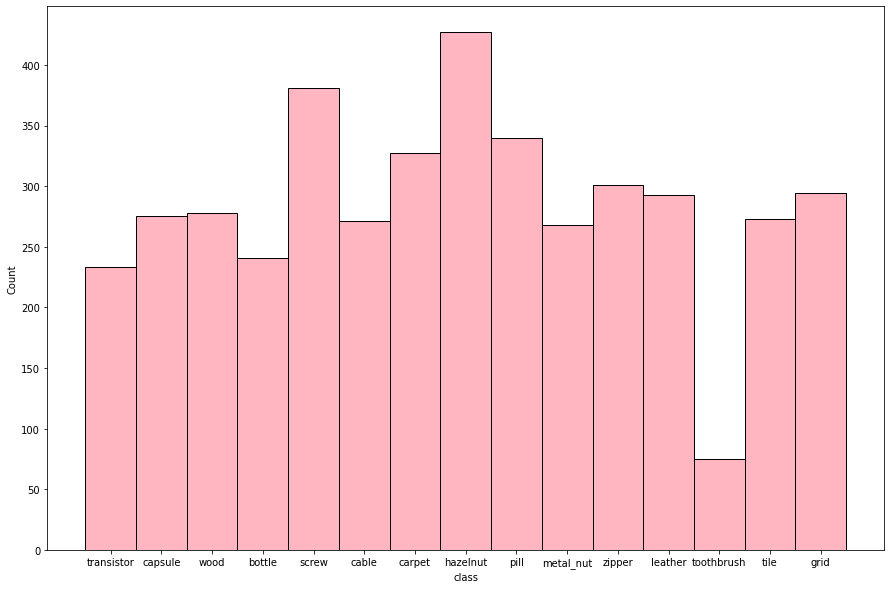

In [ ]:
rcParams['figure.figsize'] = 15, 10
sns.histplot(data=train_y, x="class", color='lightpink', alpha=1)

# Model

In [ ]:
class Custom_dataset(Dataset):
    def __init__(self, img_paths, labels, mode='train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode=mode
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        img = self.img_paths[idx]
        if self.mode=='train':
            augmentation = random.randint(0,2)
            if augmentation==1:
                img = img[::-1].copy()
            elif augmentation==2:
                img = img[:,::-1].copy()
        img = transforms.ToTensor()(img)
        if self.mode=='test':
            pass
        
        label = self.labels[idx]
        return img, label
    
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=88)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
batch_size = 16
epochs = 30

# Train
train_dataset = Custom_dataset(np.array(train_imgs), np.array(train_labels), mode='train')
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

# Test
test_dataset = Custom_dataset(np.array(test_imgs), np.array(["tmp"]*len(test_imgs)), mode='test')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

In [ ]:
import gc
gc.collect()
del train_imgs, test_imgs, train_dataset, test_dataset, train_labels
torch.cuda.empty_cache()

In [ ]:
def score_function(real, pred):
    score = f1_score(real, pred, average="macro")
    return score

model = Network().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1.5e-4)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler() 


best=0
for epoch in range(epochs):
    start=time.time()
    train_loss = 0
    train_pred=[]
    train_y=[]
    model.train()
    for batch in (train_loader):
        optimizer.zero_grad()
        x = torch.tensor(batch[0], dtype=torch.float32, device=device)
        y = torch.tensor(batch[1], dtype=torch.long, device=device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        loss = criterion(pred, y)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()/len(train_loader)
        train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
        train_y += y.detach().cpu().numpy().tolist()
        
    
    train_f1 = score_function(train_y, train_pred)

    TIME = time.time() - start
    if epoch % 3 == 0 :
        print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
        print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')

epoch : 1/24    time : 77s/1762s
TRAIN    loss : 1.03296    f1 : 0.17354
epoch : 4/24    time : 69s/1379s
TRAIN    loss : 0.23111    f1 : 0.68296
epoch : 7/24    time : 72s/1232s
TRAIN    loss : 0.09347    f1 : 0.87534
epoch : 10/24    time : 68s/952s
TRAIN    loss : 0.04275    f1 : 0.95212
epoch : 13/24    time : 68s/751s
TRAIN    loss : 0.02861    f1 : 0.96513
epoch : 16/24    time : 68s/547s
TRAIN    loss : 0.02960    f1 : 0.96894
epoch : 19/24    time : 68s/342s
TRAIN    loss : 0.01526    f1 : 0.98708
epoch : 22/24    time : 68s/136s
TRAIN    loss : 0.01070    f1 : 0.99609


# Evaluation

In [ ]:
model.eval()
f_pred = []

with torch.no_grad():
    for batch in (test_loader):
        x = torch.tensor(batch[0], dtype = torch.float32, device = device)
        with torch.cuda.amp.autocast():
            pred = model(x)
        f_pred.extend(pred.argmax(1).detach().cpu().numpy().tolist())

In [ ]:
label_decoder = {val:key for key, val in label_unique.items()}

f_result = [label_decoder[result] for result in f_pred]

In [ ]:
submission = pd.read_csv("/content/drive/MyDrive/data engineering/Deep Learning/project/open/sample_submission.csv")

submission["label"] = f_result

submission

,index,label
0,0,tile-glue_strip
1,1,grid-good
2,2,transistor-good
3,3,tile-gray_stroke
4,4,tile-good
...,...,...
2149,2149,tile-gray_stroke
2150,2150,screw-good
2151,2151,grid-good
2152,2152,cable-poke_insulation


In [ ]:
submission.to_csv('/content/drive/MyDrive/data engineering/Deep Learning/project/open/230308_2.csv', index=False)